# Domain quantization 4

Try domain quantization on mnist digits

In [1]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

def normal_distribution(n, mean, var=0.05):
    x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
    x = x / np.sum(x)
    #return torch.tensor(x).float()
    return x

In [9]:
import pandas as pd

class DomainQuantizationLayer(nn.Module):
    def __init__(self, input_features, bin_count=10, init_low_bound=0.0, init_high_bound=1.0):
        assert bin_count > 1

        super().__init__()
        self.input_features = input_features
        self.bin_count = bin_count
        self.bins = [[] for _ in range(input_features)]
        self.bins_initialized = False
        self.values_used = 0

    def forward(self, input):
        assert input.shape[0] == self.input_features, f"self.input_features is {self.input_features}, input is {input.shape}"

        # print('input shape = ', input.shape)
        if self.training or not self.bins_initialized:
            self.update_bins(input)
        return self.map_values(input)

    def extra_repr(self):
        return f"input_features = {self.input_features}, resolution = {self.resolution}"
    
    def qcut_bins(self, values):
        assert len(values.shape) == 1, "Need 1D numpy array of values"
        _, bins = pd.qcut(values, q=self.bin_count-1, retbins=True, duplicates='drop', labels=False)
        return bins

    def map_values(self, values):
        output = torch.stack([self.map_feature_values(feature_values, feature_index) for feature_index, feature_values in enumerate(values)])
        return output
        
    def map_feature_values(self, values, feature_index):
        assert len(values.shape) == 1

        bins = self.bins[feature_index]
        digits = np.digitize(values, bins)
        output = digits.astype(float)
        for index, digit in enumerate(digits):
            if digit > 0 and digit < len(bins):
                val_left = bins[digit-1]
                val_right = bins[digit]
                output[index] += (values[index] - val_left) / (val_right - val_left)

        output -= 1
        output.clip(0, len(bins) - 1, out=output)
        #output = [normal_distribution(self.bin_count, item * 1.0 / self.bin_count) for item in output]
        return torch.Tensor(output)
    
    def update_bins(self, values):
        print('alpha = ', self.values_used / (self.values_used + values.shape[-1]))
        for feature_index, feature_values in enumerate(values):
            self.update_feature_bins(feature_values, feature_index)
            
        self.bins_initialized = True
        self.values_used += values.shape[-1]
        if self.values_used > 10000:
            self.values_used = 10000
        
    def update_feature_bins(self, values, feature_index):
        alpha = self.values_used / (self.values_used + values.size)
        bins = self.qcut_bins(values)

        if not self.bins_initialized or self.bins[feature_index].shape[0] < bins.shape[0]:
            self.bins[feature_index] = bins
        else:
            if self.bins[feature_index].shape[0] == bins.shape[0]:
                self.bins[feature_index] = self.bins[feature_index] * alpha + bins * (1 - alpha)
            else:
                pass # ignore smaller size bins, we never want to reduce resolution


In [10]:
from sklearn import datasets
mnist = datasets.fetch_mldata('MNIST original', data_home='datasets/')
y = pd.Series(mnist.target).astype('int').astype('category').values
X = pd.DataFrame(mnist.data).values

In [13]:
print(X.shape)
feature_count = 28*28
dq = DomainQuantizationLayer(feature_count, bin_count=30)
batch_start_index = 10000

(70000, 784)


alpha =  0.0


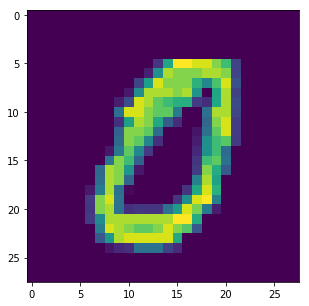

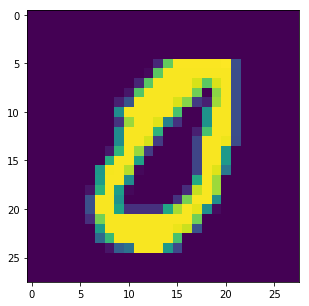

alpha =  0.5


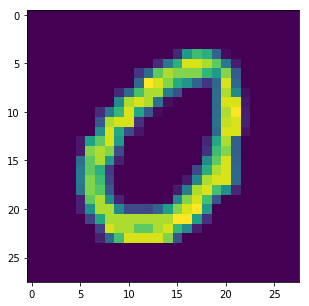

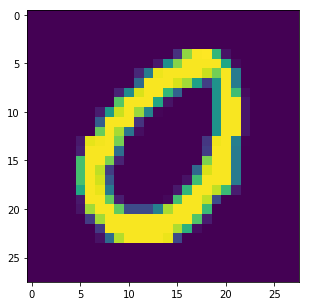

alpha =  0.6666666666666666


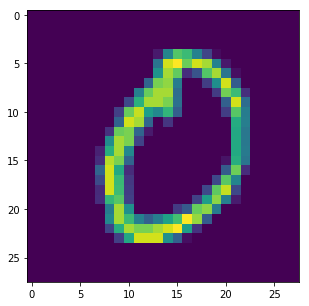

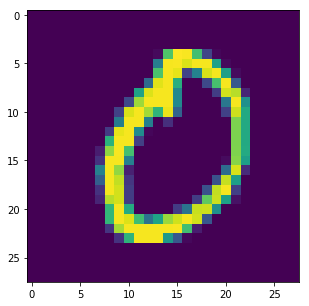

alpha =  0.75


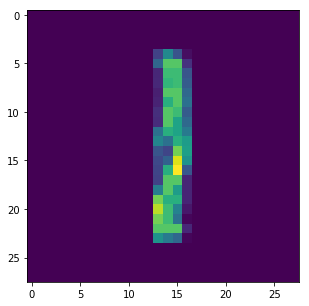

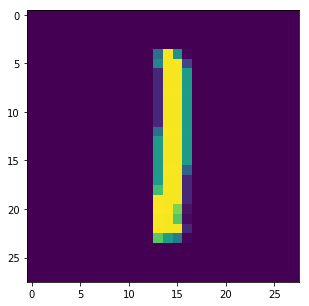

alpha =  0.8


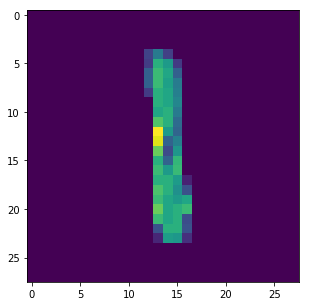

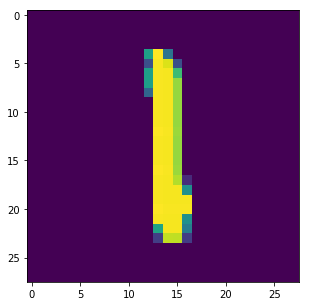

alpha =  0.8333333333333334


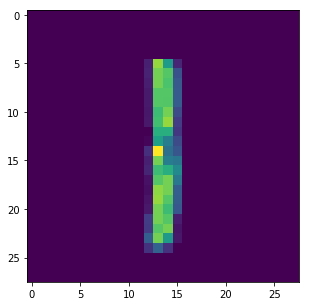

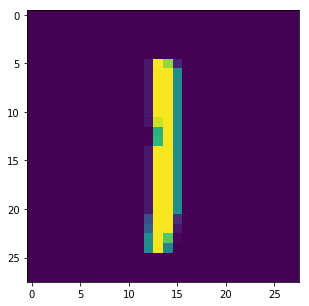

alpha =  0.8333333333333334


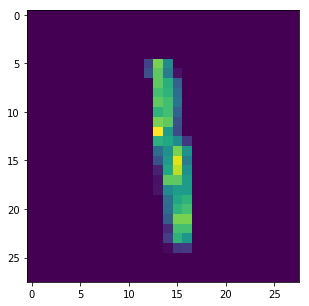

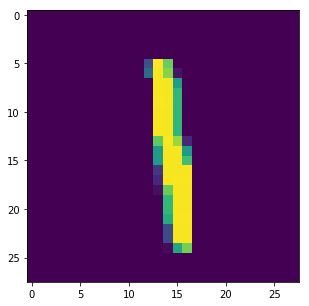

alpha =  0.8333333333333334


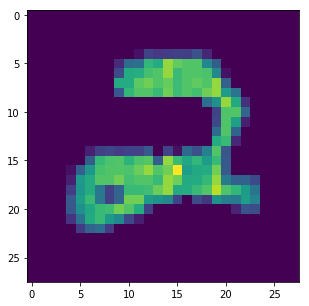

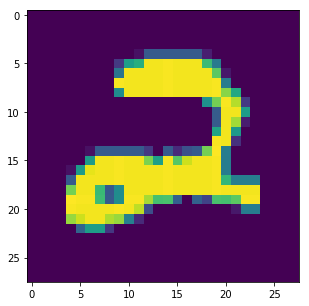

alpha =  0.8333333333333334


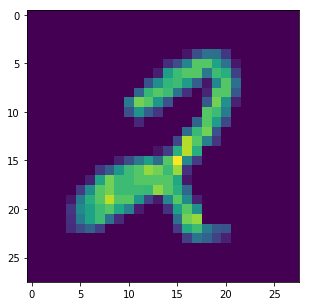

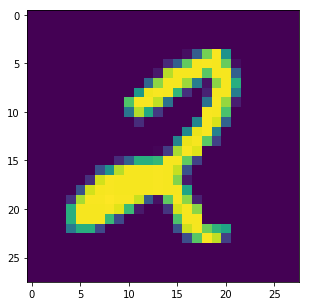

alpha =  0.8333333333333334


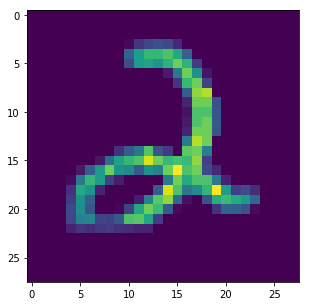

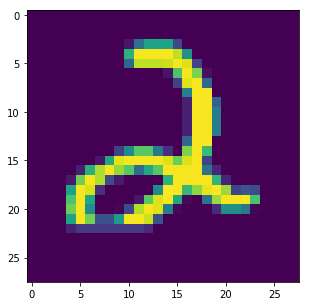

alpha =  0.8333333333333334


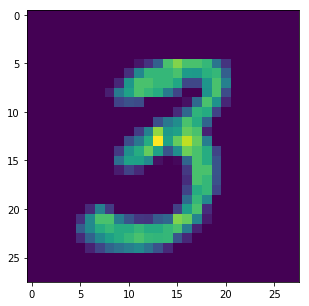

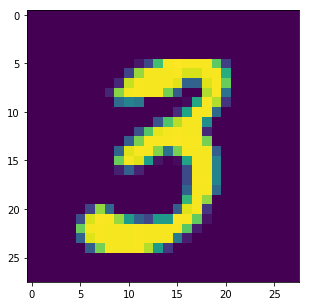

alpha =  0.8333333333333334


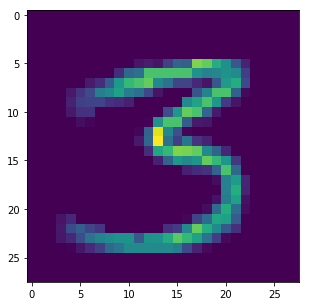

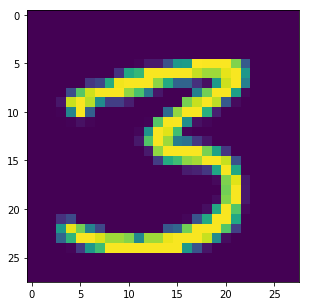

alpha =  0.8333333333333334


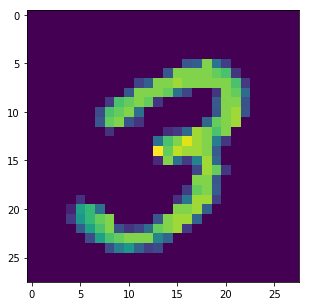

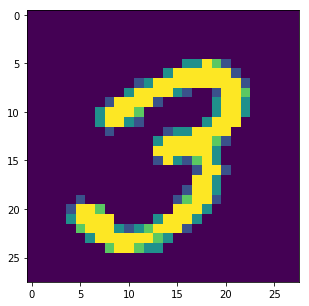

alpha =  0.8333333333333334


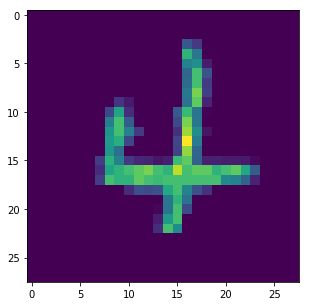

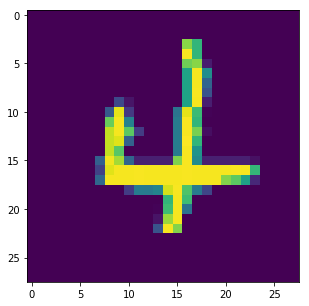

alpha =  0.8333333333333334


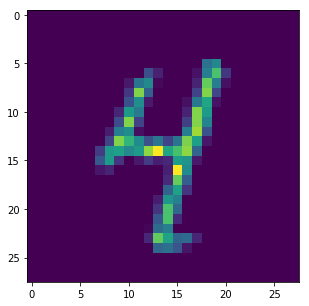

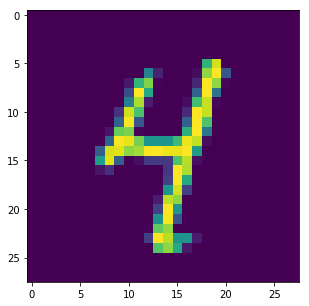

alpha =  0.8333333333333334


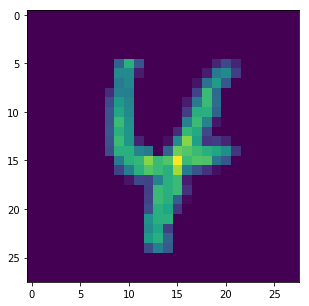

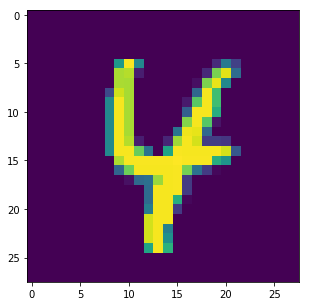

alpha =  0.8333333333333334


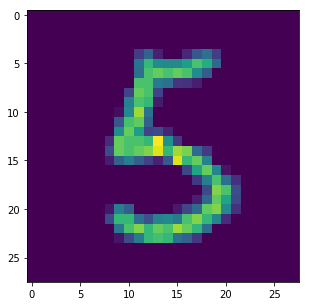

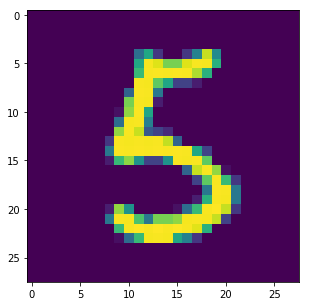

alpha =  0.8333333333333334


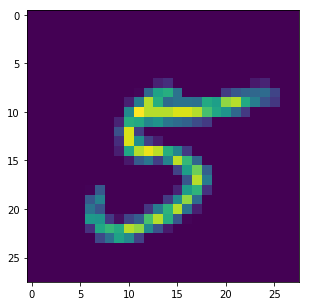

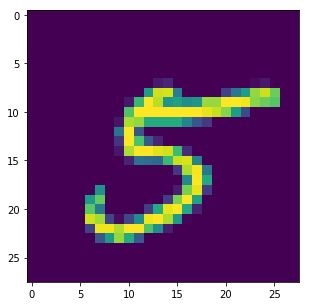

alpha =  0.8333333333333334


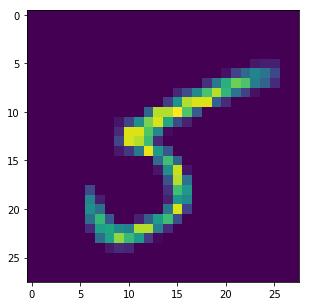

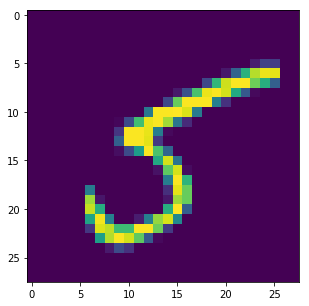

alpha =  0.8333333333333334


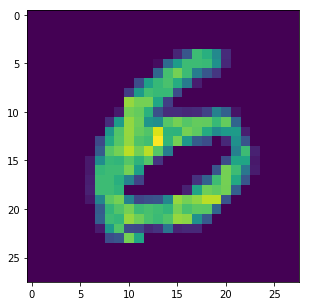

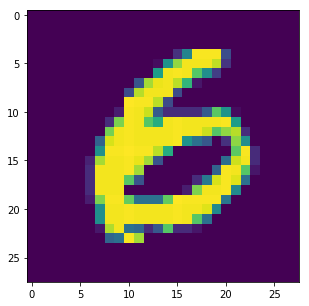

alpha =  0.8333333333333334


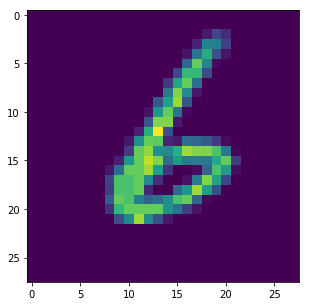

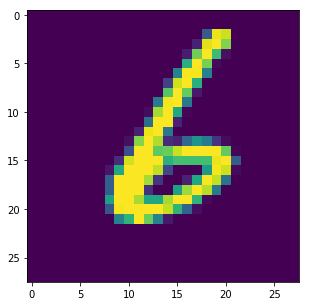

alpha =  0.8333333333333334


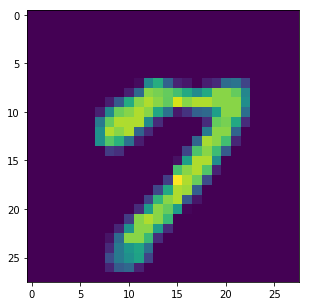

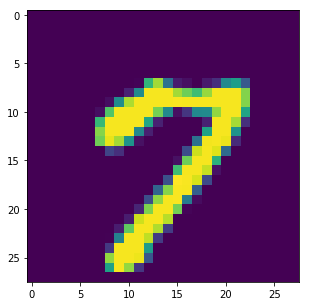

alpha =  0.8333333333333334


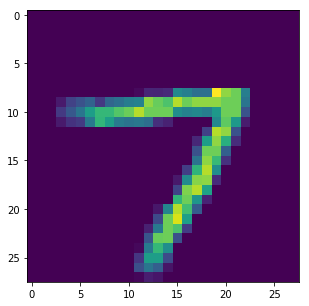

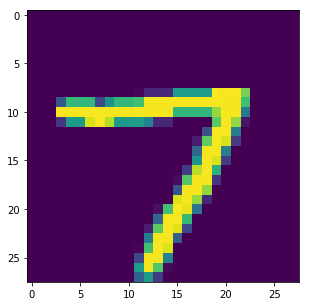

alpha =  0.8333333333333334


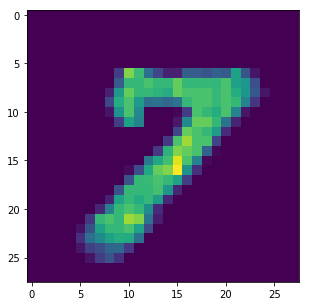

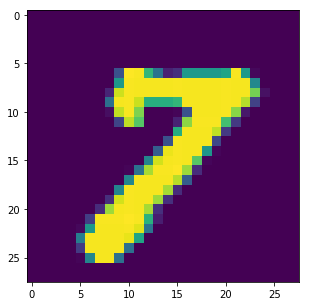

alpha =  0.8333333333333334


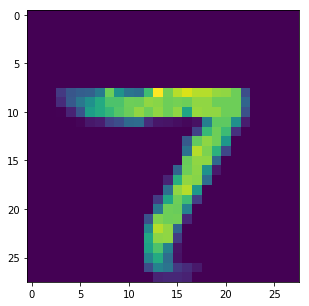

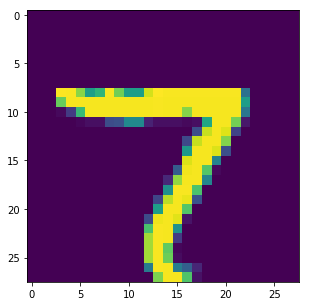

alpha =  0.8333333333333334


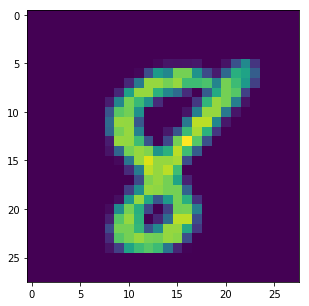

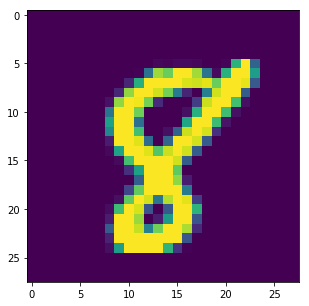

alpha =  0.8333333333333334


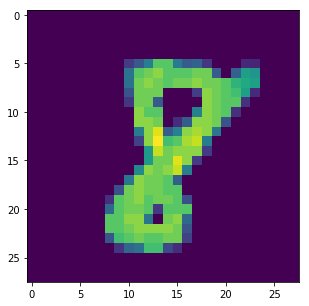

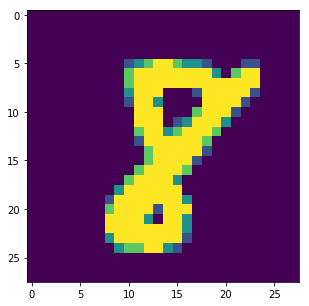

alpha =  0.8333333333333334


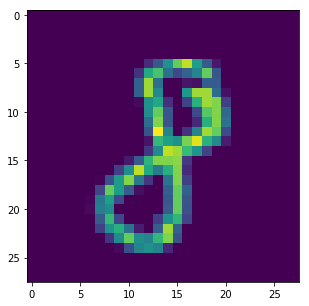

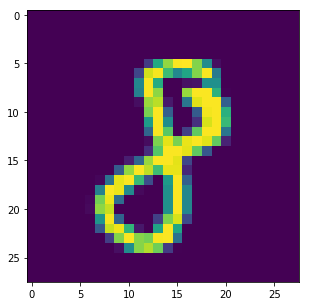

alpha =  0.8333333333333334


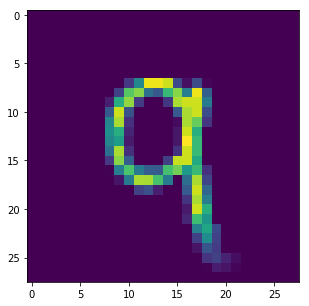

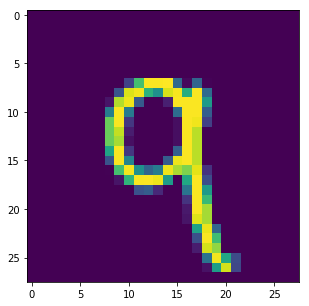

alpha =  0.8333333333333334


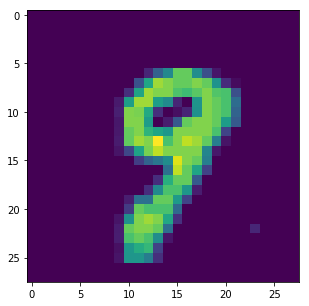

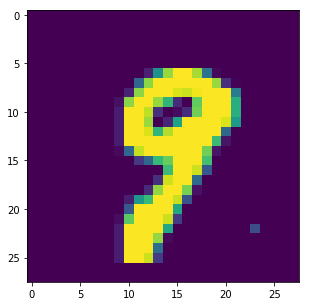

alpha =  0.8333333333333334


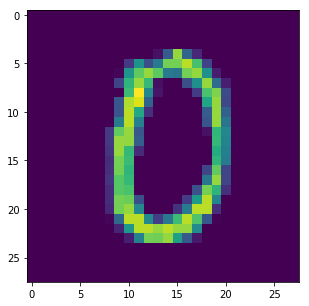

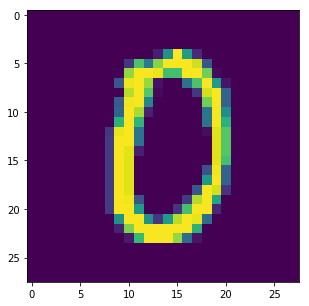

alpha =  0.8333333333333334


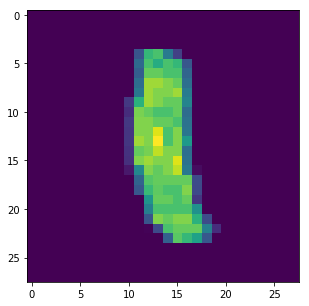

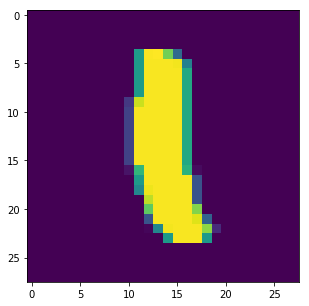

alpha =  0.8333333333333334


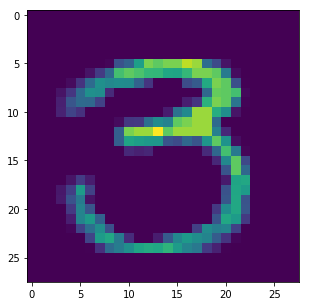

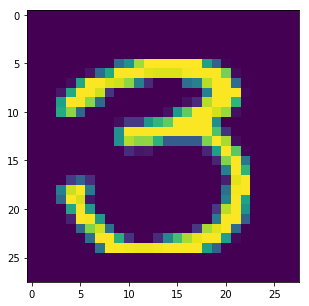

alpha =  0.8333333333333334


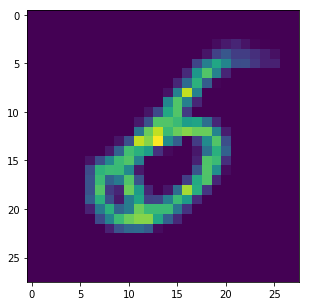

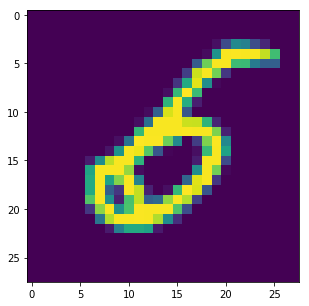

alpha =  0.8333333333333334


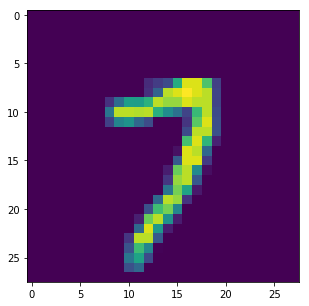

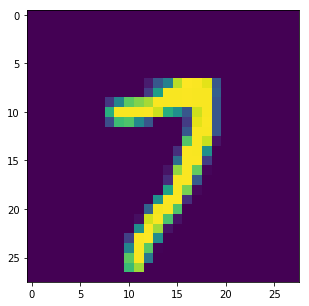

In [14]:
batch_start_index = 0
for batch in range(35):
    batch_size = 2000
    pixel_data = X[batch_start_index:batch_start_index+batch_size,:].transpose()
    output = dq(pixel_data)

    # dq = DomainQuantizationLayer(X.shape[-1], bin_count=20)
    # output = dq(X.transpose())

    output_sample = output[:, 10].numpy().reshape(28, 28)
    fig, ax1 = plt.subplots(figsize=(15, 5))
    ax1.imshow(output_sample)
    plt.show()

    input_sample = X[batch_start_index+10].reshape(28, 28)
    fig, ax1 = plt.subplots(figsize=(15, 5))
    ax1.imshow(input_sample)
    plt.show()

#     fig, ax1 = plt.subplots(figsize=(15, 5))
#     ax1.imshow(output_sample - input_sample)
#     plt.show()

    batch_start_index += batch_size

In [6]:
dq.bins

[array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([ 0.        , 12.58536585]),
 array([  0.        , 216.92682927]),
 array([  0., 216.]),
 array([0., 9.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([ 0., 16.]),
 array([0.        , 8.95121951]),
 array([  0.       , 153.2195122]),
 array([ 0.       , 14.5134464]),
 array([  0.        , 149.72356347]),
 array([  0.        , 102.90423427]),
 array([  0.        , 169.87710887]),
 array([  0.        , 162.45673418]),
 array([  0.       , 222.7757602]),
 array([  0.        , 136.45274512]),
 array([  0.        , 206.48474993]),
 array([  0.        , 137.27924511]),
 array([  0.        , 215.07267771]),
 array([  0.        , 140.1529